Without HOG feature extractor


Saving dataset.zip to dataset (1).zip
Extracted dataset at: /content
SVM Accuracy: 0.8899


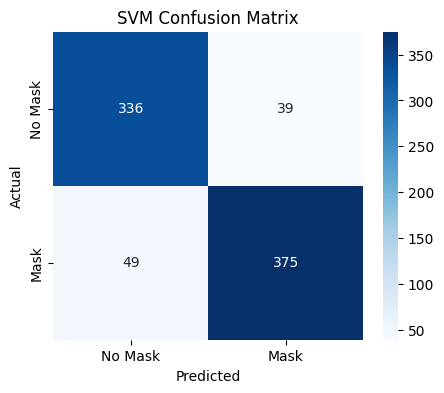

Random Forest Accuracy: 0.8611


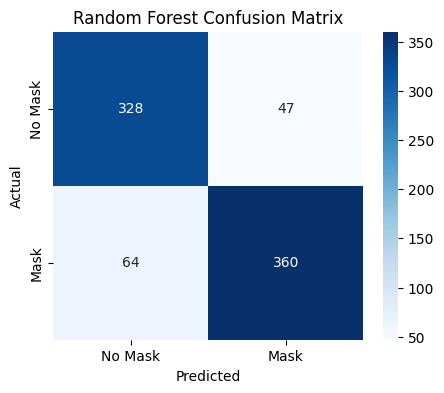

Epoch [1/30], Loss: 0.8054
Epoch [11/30], Loss: 0.1981
Epoch [21/30], Loss: 0.2443
Neural Network Accuracy: 0.8511


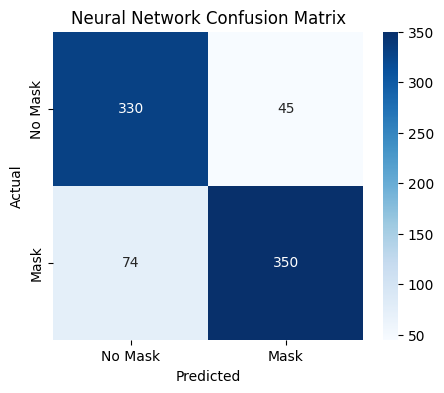

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Added for confusion matrix
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import drive
from skimage.feature import hog
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# drive.mount('/content/drive')
# import zipfile
# from google.colab import files


# uploaded = files.upload()  # Upload the ZIP file manually


# zip_path = list(uploaded.keys())[0]  # Get the uploaded file name
# extract_path = "/content"  # Extraction folder

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f"Extracted dataset at: {extract_path}")



# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask'], yticklabels=['No Mask', 'Mask'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Load images without HOG feature extraction

def load_images(image_paths, label):
    images, labels = [], []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        img = img.flatten()  # Flatten the image into a 1D array
        images.append(img)
        labels.append(label)
    return np.array(images), np.array(labels)


# uploaded = files.upload()  # Upload the ZIP file manually


# zip_path = list(uploaded.keys())[0]  # Get the uploaded file name
# extract_path = "/content/dataset"  # Extraction folder

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f"Extracted dataset at: {extract_path}")

extract_path = os.getcwd()

# 🔹 Step 3: Define Data Paths
mask_data_dir = os.path.join(extract_path, "/classification_dataset/with_mask/")
no_mask_data_dir = os.path.join(extract_path, "/classification_dataset/without_mask/")
mask_images = glob(os.path.join(mask_data_dir, "*.jpg")) + glob(os.path.join(mask_data_dir, "*.png"))
no_mask_images = glob(os.path.join(no_mask_data_dir, "*.jpg")) + glob(os.path.join(no_mask_data_dir, "*.png"))

X_mask, y_mask = load_images(mask_images, label=1)
X_no_mask, y_no_mask = load_images(no_mask_images, label=0)

X = np.concatenate((X_mask, X_no_mask), axis=0)
y = np.concatenate((y_mask, y_no_mask), axis=0)
X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM Model
svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
plot_confusion_matrix(y_test, y_pred_svm, "SVM Confusion Matrix")

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

# Neural Network
INPUT_DIM = X_train.shape[1]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(INPUT_DIM, 224)
        self.fc2 = nn.Linear(224, 224)

        self.fc3 = nn.Linear(224, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
correct, total = 0, 0
y_pred_nn, y_true_nn = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        y_pred_nn.extend(predicted.cpu().numpy())
        y_true_nn.extend(batch_y.cpu().numpy())

print(f"Neural Network Accuracy: {correct / total:.4f}")
plot_confusion_matrix(y_true_nn, y_pred_nn, "Neural Network Confusion Matrix")


With HOG feature extractor

The chosen models effectively handle high-dimensional data and mitigate the impact of irrelevant features. Since this is a supervised learning task, KNN and GMM were not considered. Logistic regression, being a linear classifier, was not included. Traditional ML methods, such as SVM and random forests, showed varying results, with random forests demonstrating greater robustness due to its ensemble nature. As expected, the neural network outperformed traditional models, leveraging its ability to learn hierarchical representations.Also,intead of simply flattening the image ,if we use handcrafted features like HoG,performance improves.Use of HOG feature extractor does'nt boost accuracy.

SVM Accuracy: 0.9349


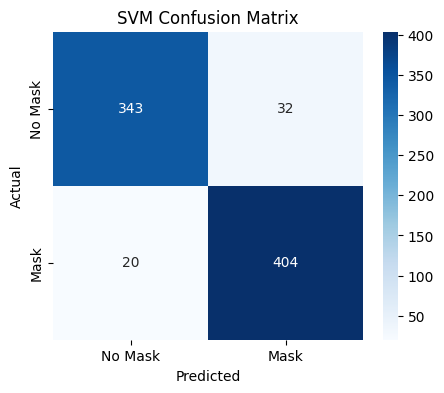

Random Forest Accuracy: 0.8886


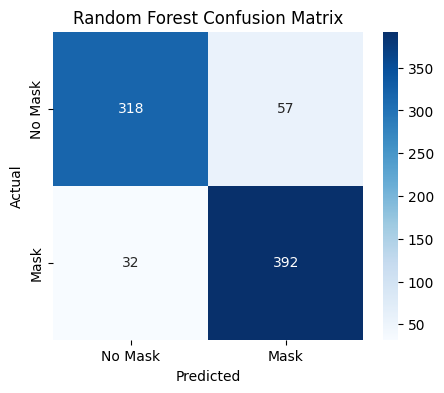

Epoch [1/30], Loss: 0.2534
Epoch [11/30], Loss: 0.0007
Epoch [21/30], Loss: 0.0000
Neural Network Accuracy: 0.9249


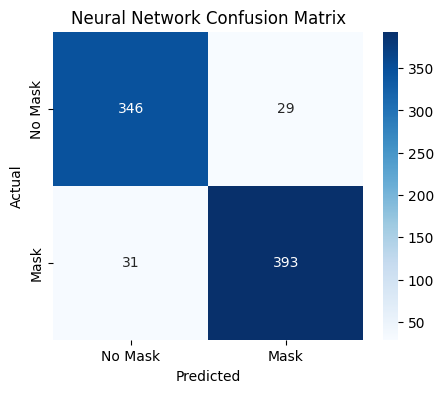

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Added for confusion matrix
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import drive
from skimage.feature import hog
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# import zipfile
# from google.colab import files


# uploaded = files.upload()  # Upload the ZIP file manually


# zip_path = list(uploaded.keys())[0]  # Get the uploaded file name
# extract_path = "/content"  # Extraction folder

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f"Extracted dataset at: {extract_path}")



# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask'], yticklabels=['No Mask', 'Mask'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

# Load images with HOG feature extraction

def load_images(image_paths, label):
    images, labels = [], []
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        features = hog(img, orientations=9, pixels_per_cell=(8, 8),
                       cells_per_block=(2, 2), block_norm='L2-Hys',
                       visualize=False, feature_vector=True)
        images.append(features)
        labels.append(label)
    return np.array(images), np.array(labels)






extract_path = os.cwd()

# 🔹 Step 3: Define Data Paths
mask_data_dir = os.path.join(extract_path, "/classification_dataset/with_mask/")
no_mask_data_dir = os.path.join(extract_path, "/classification_dataset/without_mask/")
mask_images = glob(os.path.join(mask_data_dir, "*.jpg")) + glob(os.path.join(mask_data_dir, "*.png"))
no_mask_images = glob(os.path.join(no_mask_data_dir, "*.jpg")) + glob(os.path.join(no_mask_data_dir, "*.png"))

X_mask, y_mask = load_images(mask_images, label=1)
X_no_mask, y_no_mask = load_images(no_mask_images, label=0)

X = np.concatenate((X_mask, X_no_mask), axis=0)
y = np.concatenate((y_mask, y_no_mask), axis=0)
X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM Model
svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
plot_confusion_matrix(y_test, y_pred_svm, "SVM Confusion Matrix")

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

# Neural Network
INPUT_DIM = X_train.shape[1]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(INPUT_DIM, 224)
        self.fc2 = nn.Linear(224, 224)
        self.fc3 = nn.Linear(224, 2)
        self.fc4 = nn.Linear(224, 2)
        self.fc5 = nn.Linear(224, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.fc5(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
correct, total = 0, 0
y_pred_nn, y_true_nn = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        y_pred_nn.extend(predicted.cpu().numpy())
        y_true_nn.extend(batch_y.cpu().numpy())

print(f"Neural Network Accuracy: {correct / total:.4f}")
plot_confusion_matrix(y_true_nn, y_pred_nn, "Neural Network Confusion Matrix")


Extracted dataset at: /content
SVM Accuracy: 0.8185


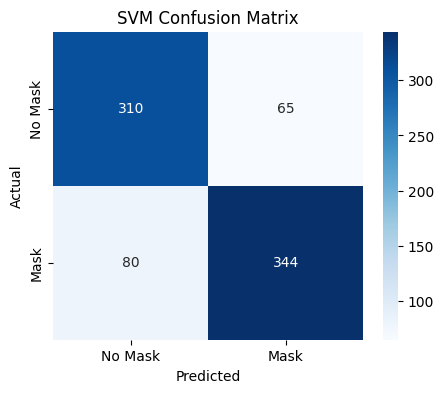

Random Forest Accuracy: 0.7947


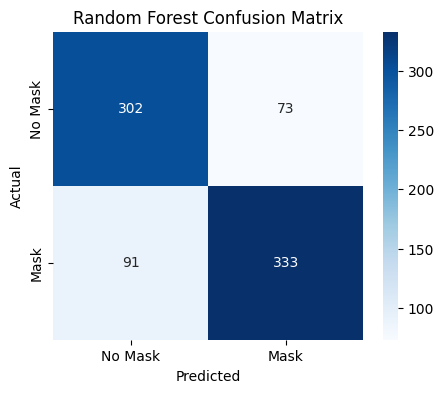

Epoch [1/30], Loss: 0.5206
Epoch [11/30], Loss: 0.2969
Epoch [21/30], Loss: 0.0495
Neural Network Accuracy: 0.8273


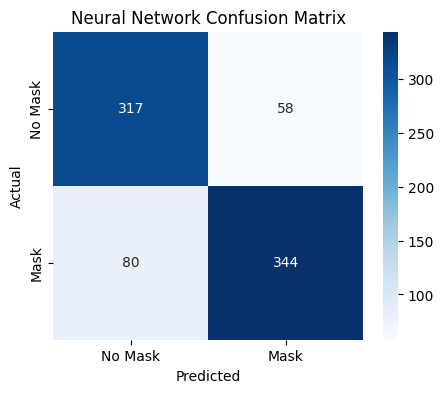

In [ ]:
!pip install opencv-contrib-python

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns  # Added for confusion matrix
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score, confusion_matrix
from google.colab import drive
from skimage.feature import hog
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset


# import zipfile
# from google.colab import files


# uploaded = files.upload()  # Upload the ZIP file manually


# zip_path = list(uploaded.keys())[0]  # Get the uploaded file name
# extract_path = "/content"  # Extraction folder

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f"Extracted dataset at: {extract_path}")



# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Mask', 'Mask'], yticklabels=['No Mask', 'Mask'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(title)
    plt.show()

def load_images(image_paths, label):
    images, labels = [], []
    sift = cv2.SIFT_create()  # Initialize SIFT
    for img_path in image_paths:
        img = cv2.imread(img_path)
        img = cv2.resize(img, (128, 128))
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        keypoints, descriptors = sift.detectAndCompute(gray, None)
        if descriptors is not None:
            # Compute the mean of the descriptors to get a fixed-length feature vector
            feature = np.mean(descriptors, axis=0)
            images.append(feature)
            labels.append(label)
        else:
            # Handle cases where no descriptors are found
            print(f"No descriptors found for image: {img_path}")
    return np.array(images), np.array(labels)






extract_path = os.cwd()

# 🔹 Step 3: Define Data Paths
mask_data_dir = os.path.join(extract_path, "/classification_dataset/with_mask/")
no_mask_data_dir = os.path.join(extract_path, "/classification_dataset/without_mask/")
mask_images = glob(os.path.join(mask_data_dir, "*.jpg")) + glob(os.path.join(mask_data_dir, "*.png"))
no_mask_images = glob(os.path.join(no_mask_data_dir, "*.jpg")) + glob(os.path.join(no_mask_data_dir, "*.png"))

X_mask, y_mask = load_images(mask_images, label=1)
X_no_mask, y_no_mask = load_images(no_mask_images, label=0)

X = np.concatenate((X_mask, X_no_mask), axis=0)
y = np.concatenate((y_mask, y_no_mask), axis=0)
X, y = shuffle(X, y, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# SVM Model
svm_model = SVC(kernel="rbf", C=10, gamma="scale")
svm_model.fit(X_train, y_train)
y_pred_svm = svm_model.predict(X_test)
print(f"SVM Accuracy: {accuracy_score(y_test, y_pred_svm):.4f}")
plot_confusion_matrix(y_test, y_pred_svm, "SVM Confusion Matrix")

# Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
print(f"Random Forest Accuracy: {accuracy_score(y_test, y_pred_rf):.4f}")
plot_confusion_matrix(y_test, y_pred_rf, "Random Forest Confusion Matrix")

# Neural Network
INPUT_DIM = X_train.shape[1]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(INPUT_DIM, 224)
        self.fc2 = nn.Linear(224, 224)
        self.fc3 = nn.Linear(224, 224)
        self.fc4 = nn.Linear(224, 224)
        self.fc5 = nn.Linear(224, 2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.dropout(x)
        x = self.relu(self.fc4(x))
        x = self.dropout(x)
        x = self.fc5(x)

        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

model.eval()
correct, total = 0, 0
y_pred_nn, y_true_nn = [], []
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
        y_pred_nn.extend(predicted.cpu().numpy())
        y_true_nn.extend(batch_y.cpu().numpy())

print(f"Neural Network Accuracy: {correct / total:.4f}")
plot_confusion_matrix(y_true_nn, y_pred_nn, "Neural Network Confusion Matrix")


#USING CNN FOR CLASSIFICATION

git version 2.34.1
cpu
Classes: ['with_mask', 'without_mask']
Number of images: 4094
Number of classes: 2


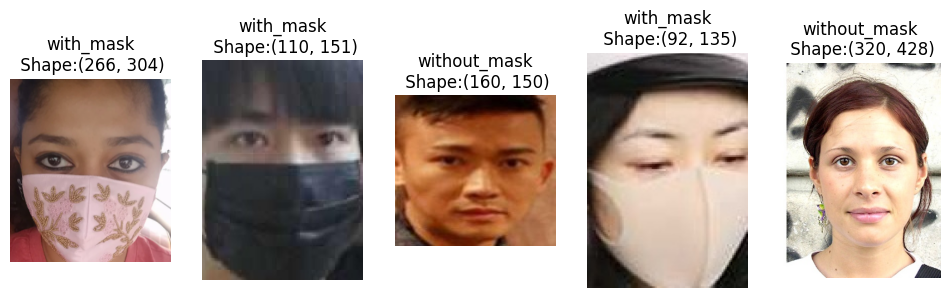

Number of training images: 3275
Number of validation images: 819
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 128]       4,194,432
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 4,287,809
Trainable params: 4,287,809
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.19
Forward/backward pass size (MB): 8.75
Params size (MB): 16.36
Estim

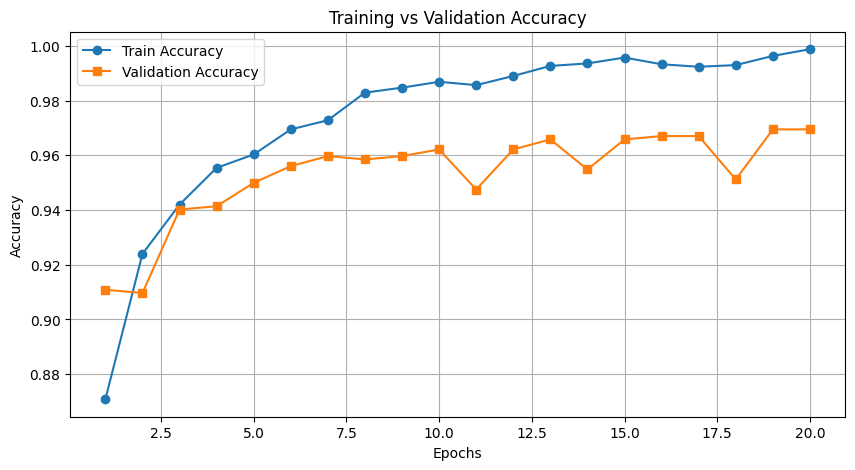

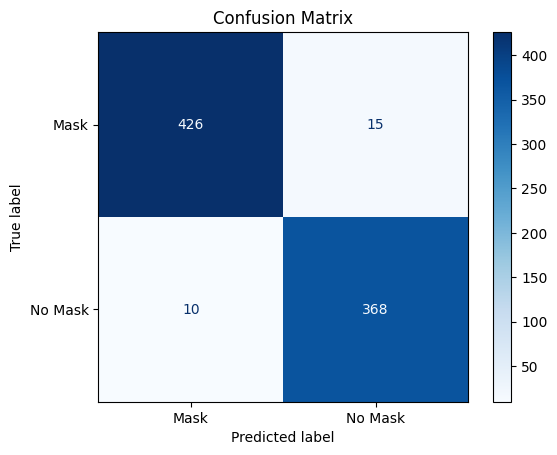

In [ ]:
# Install dependencies
!pip install torch torchvision torchaudio
!pip install torchsummary
!git --version  # This line verifies that Git is installed. Git is often required for version control or for cloning repositories.

# Imports and device configuration
import os
import torch
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import random
from torchsummary import summary
# from google.colab import drive
# drive.mount('/content/drive')
import zipfile
from google.colab import files


# uploaded = files.upload()  # Upload the ZIP file manually


# zip_path = list(uploaded.keys())[0]  # Get the uploaded file name
# extract_path = "/content"  # Extraction folder

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)

# print(f"Extracted dataset at: {extract_path}")



extract_path = os.cwd()



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# Set paths
WORKING_DIRECTORY = extract_path
dataset_path = f"{WORKING_DIRECTORY}/classification_dataset"
model_path = f"{WORKING_DIRECTORY}/cnn_models"

# Dataset loader function
def load_dataset(dataset_path, split_ratio=0.80, batch_size=32):
    train_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    val_transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
    ])

    # Create the dataset
    dataset = ImageFolder(root=dataset_path)
    class_names = dataset.classes
    print("Classes:", class_names)
    print("Number of images:", len(dataset))
    print("Number of classes:", len(class_names))

    # Display 5 random images
    fig, axes = plt.subplots(1, 5, figsize=(12, 4))
    for i in range(5):
        idx = random.randint(0, len(dataset) - 1)
        image, label = dataset[idx]
        axes[i].imshow(image)
        axes[i].set_title(f"{class_names[label]}\n Shape:{image.size}")
        axes[i].axis("off")
    plt.show()

    # Split dataset into training and validation sets
    train_size = int(split_ratio * len(dataset))
    val_size = len(dataset) - train_size
    train_data, val_data = torch.utils.data.random_split(dataset, [train_size, val_size])
    train_data.dataset.transform = train_transform
    val_data.dataset.transform = val_transform
    print("Number of training images:", len(train_data))
    print("Number of validation images:", len(val_data))

    # Create DataLoaders
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader

# Define the CNN model
import torch.nn as nn
import torch.nn.functional as F

class MaskCNN(nn.Module):
    def __init__(self):
        super(MaskCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(128 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, 1)  # Binary classification
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 128 * 16 * 16)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = torch.sigmoid(self.fc2(x))
        return x

# Training function
def training(num_epochs, model, loss_function, optimizer, train_loader, val_loader, model_weights_path=None, start_epoch=0, model_name="mask_cnn_3_layer"):
    if model_weights_path is not None:
        model.load_state_dict(torch.load(model_weights_path))
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    best_validation_accracy = 0

    for epoch in range(start_epoch, num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            predictions = (outputs > 0.5).float()
            correct_train += (predictions == labels).sum().item()
            total_train += labels.size(0)
        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        # Validation
        model.eval()
        correct_val = 0
        total_val = 0
        running_val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device).float().view(-1, 1)
                outputs = model(images)
                loss = loss_function(outputs, labels)
                running_val_loss += loss.item()
                predictions = (outputs > 0.5).float()
                correct_val += (predictions == labels).sum().item()
                total_val += labels.size(0)
        val_loss = running_val_loss / len(val_loader)
        val_acc = correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        if val_acc > best_validation_accracy:
            print(f"best model at {epoch+1}")
            torch.save(model.state_dict(), f"{model_path}/{model_name}_best_model.pth")
            best_validation_accracy = val_acc

        print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    model.load_state_dict(torch.load(f"{model_path}/{model_name}_best_model.pth"))
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Functions for plotting and evaluating performance
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies):
    num_epochs = len(train_losses)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy', marker='o')
    plt.plot(range(1, num_epochs+1), val_accuracies, label='Validation Accuracy', marker='s')
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Training vs Validation Accuracy")
    plt.legend()
    plt.grid()
    plt.show()

def compute_confusion_matrix(model, val_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).float().view(-1, 1)
            outputs = model(images)
            predictions = (outputs > 0.5).float()
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Mask", "No Mask"])
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()

# Create directory for model saving
model_path = f"{WORKING_DIRECTORY}/cnn_models/3_layer_cnn_sigmoid_adam"
os.makedirs(model_path, exist_ok=True)

# Main function to run the CNN training and evaluation
def cnn_3_layer():
    train_loader, val_loader = load_dataset(dataset_path)
    lr = 0.001
    num_epochs = 20
    model = MaskCNN()
    model.to(device)
    summary(model, input_size=(3, 128, 128))
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

    model, train_loss, val_loss, train_accuracy, val_accuracy = training(
        num_epochs, model, loss_function, optimizer, train_loader, val_loader,
        model_weights_path=None, start_epoch=0, model_name="mask_cnn_3_layer"
    )

    train_accuracies.extend(train_accuracy)
    val_accuracies.extend(val_accuracy)
    train_losses.extend(train_loss)
    val_losses.extend(val_loss)

    plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
    compute_confusion_matrix(model, val_loader)

# Run the training and evaluation
cnn_3_layer()







Model training with high learning rate
Classes: ['with_mask', 'without_mask']
Number of images: 4094
Number of classes: 2
Number of training images: 3275
Number of validation images: 819
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 128]       4,194,432
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 4,287,809
Trainable params: 4,287,809
Non-trainable params: 0
--------------------------------

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


best model at 1
Epoch 1: Train Loss: 51.8351, Train Acc: 0.4757, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 2: Train Loss: 52.5651, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 3: Train Loss: 52.6230, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 4: Train Loss: 52.7968, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 5: Train Loss: 52.6230, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 6: Train Loss: 52.6230, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 7: Train Loss: 52.3913, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 8: Train Loss: 52.4492, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 9: Train Loss: 52.5072, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 10: Train Loss: 52.5651, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 11: Train Loss: 52.5072, Train Acc: 0.4739, Val Loss: 53.5805, Val Acc: 0.4615
Epoch 12: Train Loss: 52.3913, Train Acc: 0.4739, Val Loss

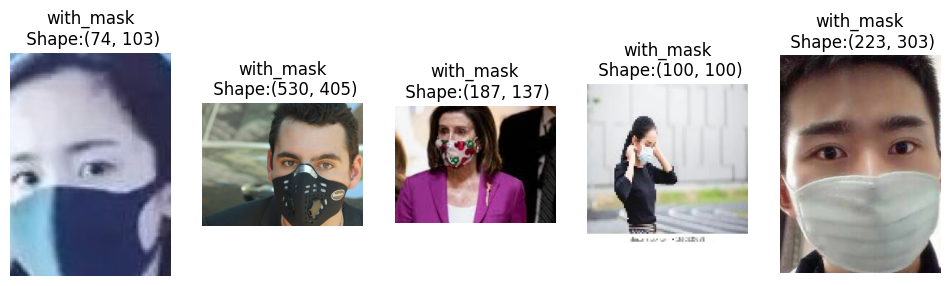

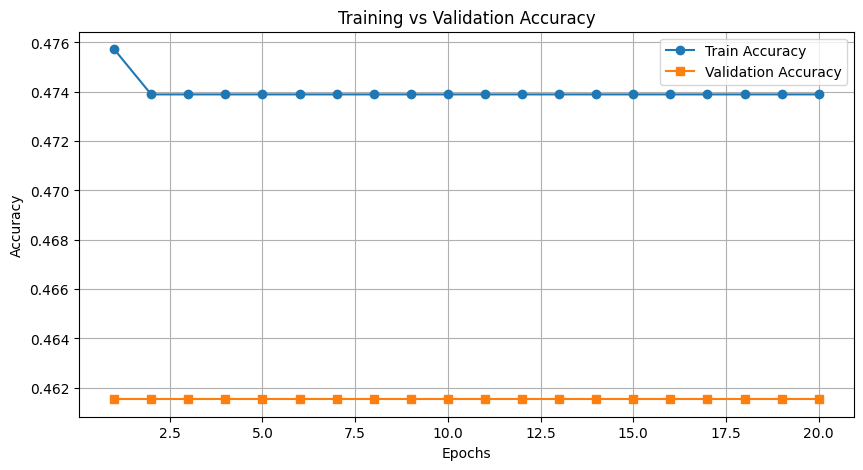

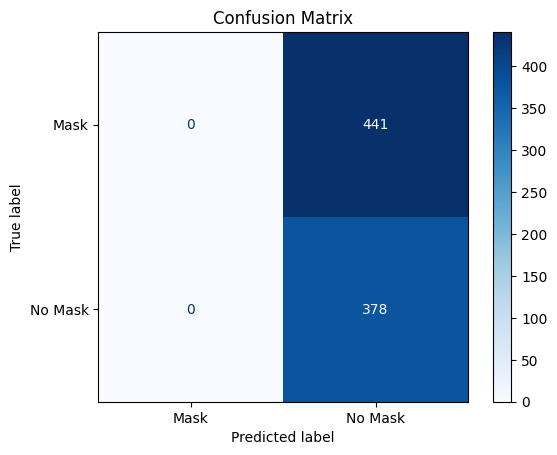

In [ ]:
model_path = f"{WORKING_DIRECTORY}/cnn_models/3_layer_cnn_sigmoid_adam_learning_rate_0.01"
os.makedirs(model_path, exist_ok=True)

def cnn_3_layer_high_lr():
    train_loader,val_loader = load_dataset(dataset_path)
    lr = 0.01
    num_epochs = 20
    model = MaskCNN()
    model.to(device)
    summary(model, input_size = (3, 128, 128))
    loss_function = nn.BCELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr= lr)
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    
    
    model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs, model,loss_function,optimizer,train_loader,val_loader,model_weights_path=None,start_epoch=0,model_name="mask_cnn_3_layer_lr_0.01")
    train_accuracies.extend(train_accuracy)
    val_accuracies.extend(val_accuracy)
    train_losses.extend(train_loss)
    val_losses.extend(val_loss)
    plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
    
    compute_confusion_matrix(model, val_loader)


print("Model training with high learning rate")

cnn_3_layer_high_lr()



Model training with high learning rate
Classes: ['with_mask', 'without_mask']
Number of images: 4094
Number of classes: 2
Number of training images: 3275
Number of validation images: 819
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 128]       4,194,432
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 4,287,809
Trainable params: 4,287,809
Non-trainable params: 0
--------------------------------

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


best model at 1
Epoch 1: Train Loss: 0.4054, Train Acc: 0.8391, Val Loss: 0.2243, Val Acc: 0.9158
best model at 2
Epoch 2: Train Loss: 0.2970, Train Acc: 0.8882, Val Loss: 0.1688, Val Acc: 0.9341
best model at 3
Epoch 3: Train Loss: 0.2366, Train Acc: 0.9093, Val Loss: 0.1459, Val Acc: 0.9487
Epoch 4: Train Loss: 0.2179, Train Acc: 0.9151, Val Loss: 0.1583, Val Acc: 0.9463
Epoch 5: Train Loss: 0.2131, Train Acc: 0.9191, Val Loss: 0.1459, Val Acc: 0.9414
Epoch 6: Train Loss: 0.1873, Train Acc: 0.9313, Val Loss: 0.1315, Val Acc: 0.9487
Epoch 7: Train Loss: 0.1955, Train Acc: 0.9307, Val Loss: 0.1472, Val Acc: 0.9487
best model at 8
Epoch 8: Train Loss: 0.1941, Train Acc: 0.9249, Val Loss: 0.1281, Val Acc: 0.9548
Epoch 9: Train Loss: 0.1581, Train Acc: 0.9386, Val Loss: 0.1417, Val Acc: 0.9463
Epoch 10: Train Loss: 0.1427, Train Acc: 0.9447, Val Loss: 0.1295, Val Acc: 0.9536
Epoch 11: Train Loss: 0.1454, Train Acc: 0.9469, Val Loss: 0.1968, Val Acc: 0.9182
Epoch 12: Train Loss: 0.1320, Tr

<ipython-input-14-a4c415f6b664>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_path}/{model_name}_best_model.pth"))


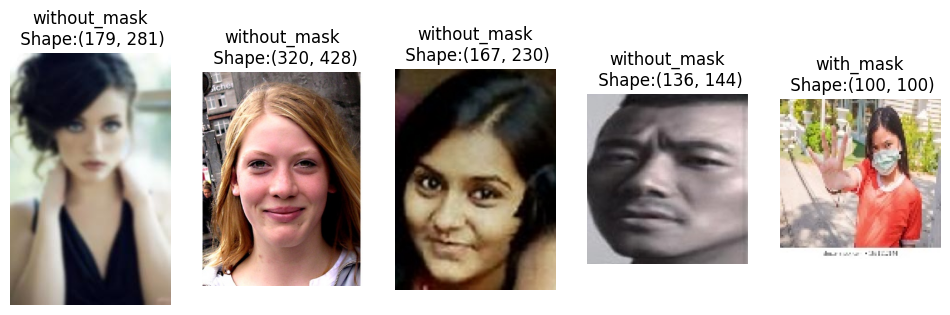

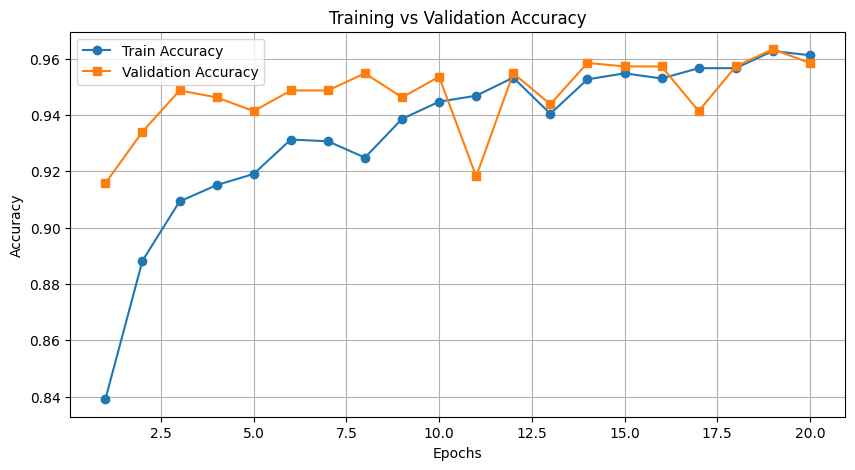

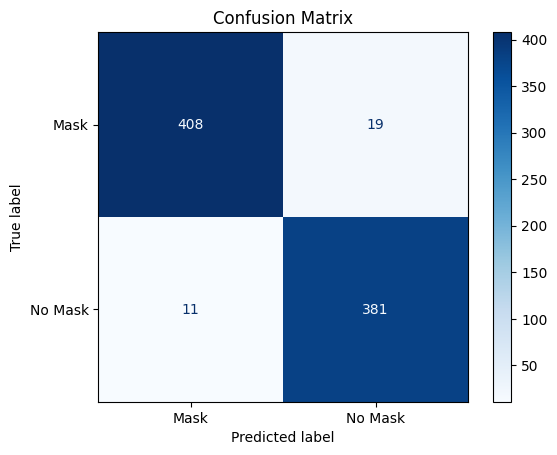

In [ ]:
#adam with weight decaying, increased learning rate

model__name = "3_layer_cnn_sigmoid_adam_weight_decay_0.005"
model_path = f"{WORKING_DIRECTORY}/cnn_models/{model__name}"
os.makedirs(model_path, exist_ok=True)

def cnn_3_layer_adam_weight_decay():
    train_loader,val_loader = load_dataset(dataset_path)
    lr = 0.005
    num_epochs = 20
    weight_decay = 1e-4
    
    model = MaskCNN()
    model.to(device)
    summary(model, input_size = (3, 128, 128))
    loss_function = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    
    
    model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs, model,loss_function,optimizer,train_loader,val_loader,model_weights_path=None,start_epoch=0,model_name=model__name)
    train_accuracies.extend(train_accuracy)
    val_accuracies.extend(val_accuracy)
    train_losses.extend(train_loss)
    val_losses.extend(val_loss)
    plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
    
    compute_confusion_matrix(model, val_loader)


print("Model training with high learning rate")

cnn_3_layer_adam_weight_decay()


Model training with high learning rate
Classes: ['with_mask', 'without_mask']
Number of images: 4094
Number of classes: 2
Number of training images: 3275
Number of validation images: 819
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
         MaxPool2d-2           [-1, 32, 64, 64]               0
            Conv2d-3           [-1, 64, 64, 64]          18,496
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 32, 32]          73,856
         MaxPool2d-6          [-1, 128, 16, 16]               0
            Linear-7                  [-1, 128]       4,194,432
           Dropout-8                  [-1, 128]               0
            Linear-9                    [-1, 1]             129
Total params: 4,287,809
Trainable params: 4,287,809
Non-trainable params: 0
--------------------------------

<ipython-input-14-a4c415f6b664>:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f"{model_path}/{model_name}_best_model.pth"))


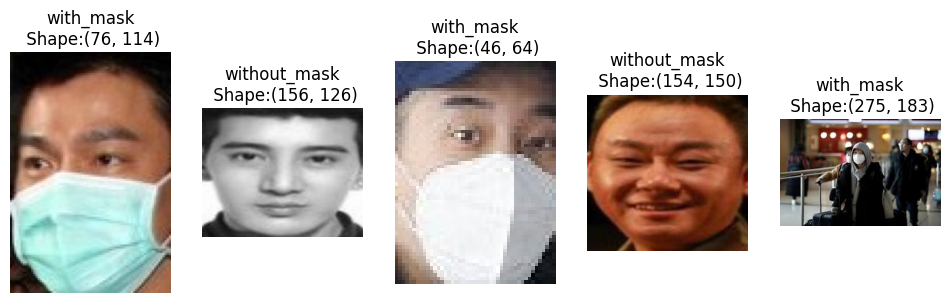

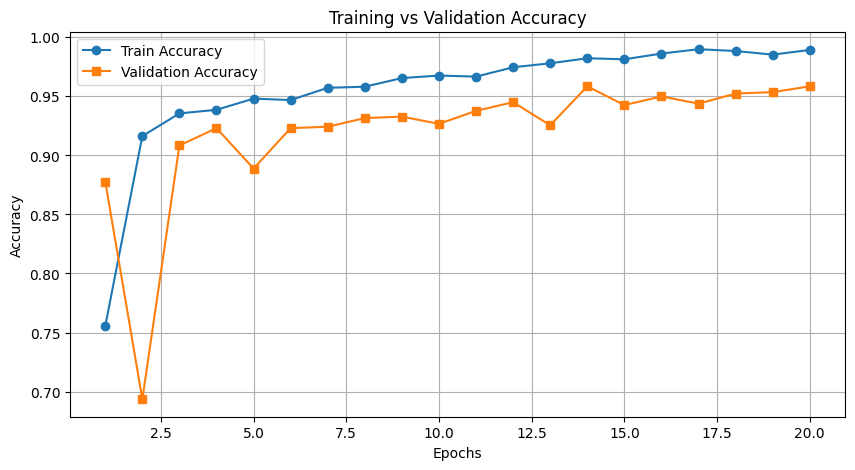

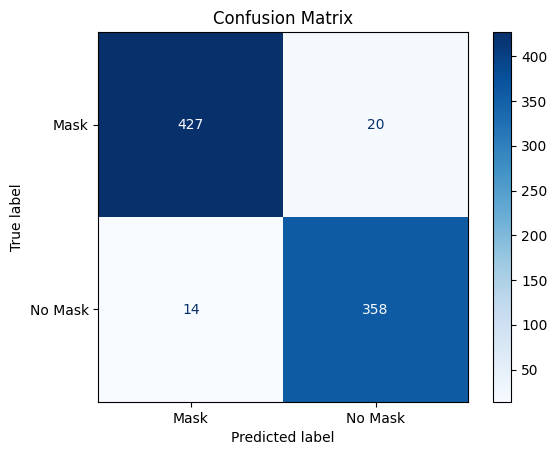

In [ ]:
model_path = f"{WORKING_DIRECTORY}/cnn_models/3_layer_cnn_sigmoid_rmsprop_l2_regularization"
os.makedirs(model_path, exist_ok=True)

def cnn_3_layer_rmpsrop_regularization():
    train_loader,val_loader = load_dataset(dataset_path)
    lr = 0.001
    num_epochs = 20
    weight_decay = 1e-5
    
    model = MaskCNN()
    model.to(device)
    summary(model, input_size = (3, 128, 128))
    loss_function = nn.BCELoss()
    optimizer = optim.RMSprop(model.parameters(), lr=lr, weight_decay=weight_decay)
    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []
    
    
    model, train_loss, val_loss, train_accuracy, val_accuracy = training(num_epochs, model,loss_function,optimizer,train_loader,val_loader,model_weights_path=None,start_epoch=0,model_name="mask_cnn_3_layer_rmsprop_l2_regular")
    train_accuracies.extend(train_accuracy)
    val_accuracies.extend(val_accuracy)
    train_losses.extend(train_loss)
    val_losses.extend(val_loss)
    plot_accuracy_loss(train_losses, val_losses, train_accuracies, val_accuracies)
    
    compute_confusion_matrix(model, val_loader)


print("Model training with high learning rate")

cnn_3_layer_rmpsrop_regularization()


OBJECTIVE:---To conpare performances of different traditional classifiers including neural network and CNN--and show CNN outperforms them all.

DATASET:--the dataset was initially a folder,which was zipped to upload to goggle colab and then unzipped from there,it has 2 subfolders with_mask and without_mask of images with masked and without mask images respectively,in jpg and png formats.



CONCLUSION:--

For feature extraction ,once plain flattening and once hog was used,hog showed better performance .
The chosen models are Random forests with 100 decision trees,Svm,and 3 layers Neural n/w(with 1 hidden layer)effectively handle high-dimensional data and mitigate the impact of irrelevant features. Since this is a supervised learning task, KNN and GMM were not considered. Logistic regression,being a linear classifier, was not included. Traditional ML methods, such as SVM and random forests, showed varying results, with SVM performing better. As expected, the neural network outperformed traditional models, leveraging its ability to learn hierarchical representations.On using HOG feature extraction,the accuracy further improved for the traditionalo methods as expected,but CNN still outperforms the traditional methods ,including Neural network of 3 layers(1 hidden),that was used(an  attempt to use a 6 layer Neural network showed overfitting,with 0 train loss and very high test losses.)For sift we have tried using a 5 layer neural network and it has shown lower performance as compared to 3 layer hog nn.
To do SIFT , the SIFT descriptors for the  images have variable lengths (since different images yield a different number of keypoints), so when we tried to create a NumPy array, the elements were of different sizes.

A simple fix is to convert the descriptors for each image into a fixed-length feature vector by taking the mean of all descriptors for that image. This way, regardless of how many keypoints are detected, we got a 128-dimensional vector (since each SIFT descriptor is of length 128).

HOW TO RUN:-
To run each part of code,the zipped file dataset.zip is to be loaded when asked